<a href="https://colab.research.google.com/github/aksb15/Python/blob/ML-projects/FINAL_Sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path

In [ ]:
# Better rendering
from IPython.core.display import HTML
HTML("<style>.rendered_html th {max-width: 120px;}</style>")

warnings.filterwarnings('ignore')

# settings to display all columns
pd.set_option("display.max_columns", None)

In [ ]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

In [ ]:
# Sales Data: Training Set (1-1913) + Validation Set (1914-1941)
sales = pd.read_csv('Data/sales_train_evaluation.csv')
sales.name = 'sales'

print("{:,} records for training data".format(len(sales)))

# Calendar
calendar = pd.read_csv('Data/calendar.csv')
calendar.name = 'calendar'
print("{:,} records for calendar data".format(len(calendar)))

# Pricing
prices = pd.read_csv('Data/sell_prices.csv')
prices.name = 'prices'
print("{:,} records for price data".format(len(prices)))

30,490 records for training data
1,969 records for calendar data
6,471,908 records for price data


In [ ]:
sales.isnull().sum().sum()

0

In [ ]:
calendar.isnull().sum().sum()

7542

In [ ]:
prices.isnull().sum().sum()

1

In [ ]:
prices.dropna()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6471902,WI_3,HOUSEHOLD_2_345,11210,5.84
6471903,WI_3,HOUSEHOLD_2_345,11211,5.84
6471904,WI_3,HOUSEHOLD_2_345,11212,5.84
6471905,WI_3,HOUSEHOLD_2_345,11213,5.84


In [ ]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [ ]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
list(calendar)

['date',
 'wm_yr_wk',
 'weekday',
 'wday',
 'month',
 'year',
 'd',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI']

In [ ]:
list(prices)

['store_id', 'item_id', 'wm_yr_wk', 'sell_price']

In [ ]:
# Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [ ]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [ ]:
# Downcast in order to save memory
# from the work of https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling/notebook
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        # Integer
        if 'int' in str(t):
            # Check if minimum and maximum are in the limit of int8
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            # Check if minimum and maximum are in the limit of int16
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            # Check if minimum and maximum are in the limit of int32
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            # Choose int64
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # Float
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        # Object
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

# # Apply downcasting
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [ ]:
# Calculate Average price for all stores
df_mean_store = pd.DataFrame(prices.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean())
df_mean_store.columns = ['item_sells_price_avg']
df_mean_store.reset_index(inplace = True)

In [ ]:
df_mean_store.head()

,item_id,wm_yr_wk,item_sells_price_avg
0,FOODS_1_001,11101,2.0
1,FOODS_1_001,11102,2.0
2,FOODS_1_001,11103,2.0
3,FOODS_1_001,11104,2.0
4,FOODS_1_001,11105,2.0


In [ ]:
# Combine with calendar
prices_new = pd.merge(prices, df_mean_store, on=['item_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719


In [ ]:
# Price difference with same items in other stores
prices_new['delta_price_all_rel'] = (prices_new['sell_price'] - prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097


In [ ]:
# Price difference with last week
prices_new['item_store'] = prices_new['item_id'].astype(str) + '_' + prices_new['store_id'].astype(str)
prices_new['item_store_change'] = prices_new["item_store"].shift() != prices_new["item_store"]

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False


In [ ]:
# Price difference week n - week n-1
prices_new['delta_price_weekn-1'] = (prices_new['sell_price']- prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change,delta_price_weekn-1
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True,0.000000
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False,0.000000
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False,-0.137817
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000


In [ ]:
# Average price of the department by store
prices_new['dept_id'] = prices_new.item_id.str[:-4]
df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
df_mean_cat.columns = ['dept_sells_price_avg']
df_mean_cat.reset_index(inplace = True)

In [ ]:
# Combine with price dataset
prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk']
                          , how='left', suffixes=('', '_y'))
prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change,delta_price_weekn-1,dept_id,dept_sells_price_avg
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True,0.000000,HOBBIES_1,6.099359
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.252128
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False,-0.137817,HOBBIES_1,6.235187
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968


In [ ]:
# Cannibalisation: compare this item price with average of the department (category)
prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] - prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']

In [ ]:
# Drop columns
prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'dept_id', 'item_store',
                    'dept_sells_price_avg'], axis = 1, inplace = True)

In [ ]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,0.000000,0.000000,0.570350
1,CA_1,HOBBIES_1_001,11326,9.578125,0.058356,0.000000,0.531978
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.059237,-0.137817,0.324389
3,CA_1,HOBBIES_1_001,11328,8.257812,-0.024097,0.000000,0.324435
4,CA_1,HOBBIES_1_001,11329,8.257812,-0.024097,0.000000,0.324435


In [ ]:
 #Melt Data to show sales per day of every item
#Convert from wide to long format (records on row level)

df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
             var_name='d', value_name='sold').dropna()
print("{:,} records to combine with calendar and price".format(len(df)))
df.head()

60,034,810 records to combine with calendar and price


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
#Combine all in one dataset
# Combine with calendar
df = pd.merge(df, calendar, on='d', how='left')
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Combine with price
df = pd.merge(df, prices_new, on=['store_id','item_id','wm_yr_wk'], how='left')

In [ ]:
print("{:,} records in df".format(len(df)))
df.head()

60,034,810 records in df


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN


In [ ]:
corrM = df.corr()

In [ ]:
corrM

,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
sold,1.000000,2.662258e-02,-2.820079e-02,6.510403e-05,2.620903e-02,1.095256e-02,1.284713e-02,1.304629e-02,-0.148588,-4.705762e-03,-0.000017,-1.201646e-01
wm_yr_wk,0.026623,1.000000e+00,-2.239616e-03,-4.448848e-02,9.892288e-01,7.157404e-04,2.461955e-03,2.663709e-03,0.019482,3.350033e-09,-0.000151,-3.011196e-10
wday,-0.028201,-2.239616e-03,1.000000e+00,-8.451165e-04,1.517281e-03,1.970679e-03,8.910275e-04,-3.427577e-03,-0.000033,3.921795e-12,0.000003,-1.500358e-11
month,0.000065,-4.448848e-02,-8.451165e-04,1.000000e+00,-1.718363e-01,-3.668969e-03,-3.668969e-03,-3.668969e-03,0.000394,-6.523680e-10,0.000384,2.346606e-10
year,0.026209,9.892288e-01,1.517281e-03,-1.718363e-01,1.000000e+00,8.541006e-03,8.541006e-03,8.541006e-03,0.019112,3.390605e-09,-0.000205,-3.309969e-10
snap_CA,0.010953,7.157404e-04,1.970679e-03,-3.668969e-03,8.541006e-03,1.000000e+00,4.028810e-01,4.028810e-01,-0.000083,2.531724e-10,-0.000016,8.460509e-11
snap_TX,0.012847,2.461955e-03,8.910275e-04,-3.668969e-03,8.541006e-03,4.028810e-01,1.000000e+00,5.521607e-01,0.000032,1.124776e-10,-0.000199,2.697171e-11
snap_WI,0.013046,2.663709e-03,-3.427577e-03,-3.668969e-03,8.541006e-03,4.028810e-01,5.521607e-01,1.000000e+00,0.000039,1.436665e-10,-0.000229,5.889366e-11
sell_price,-0.148588,1.948248e-02,-3.316133e-05,3.939679e-04,1.911159e-02,-8.285592e-05,3.248462e-05,3.918825e-05,1.000000,4.764850e-02,0.001193,8.791470e-01
delta_price_all_rel,-0.004706,3.350033e-09,3.921795e-12,-6.523680e-10,3.390605e-09,2.531724e-10,1.124776e-10,1.436665e-10,0.047649,1.000000e+00,0.016579,5.421647e-02


In [ ]:
#Label Encoding

# Change Store id to category type
df.store_id = df.store_id.astype('category')
df.item_id = df.item_id.astype('category')
df.cat_id = df.cat_id.astype('category')
df.state_id = df.state_id.astype('category')
df.id = df.id.astype('category')
df.dept_id = df.dept_id.astype('category')

# Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))

# Item, Department and Categories
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))

# Stores and States
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

# Save to DataFrame
LIST_SAVE = [d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
for list_save, list_name in zip(LIST_SAVE, LIST_NAME):
    pickle.dump(list_save, open('Data/General/{}.p'.format(list_name), "wb"))

In [ ]:
# Mapping with Category Codes

# Remove d_ and transform to int (dates)
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

# Transform categorical data to codes
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

# Drop Dates
df.drop('date',axis=1,inplace=True)
print("Dataframe shape: {}".format(df.shape))
df.head()

Dataframe shape: (60034810, 24)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN


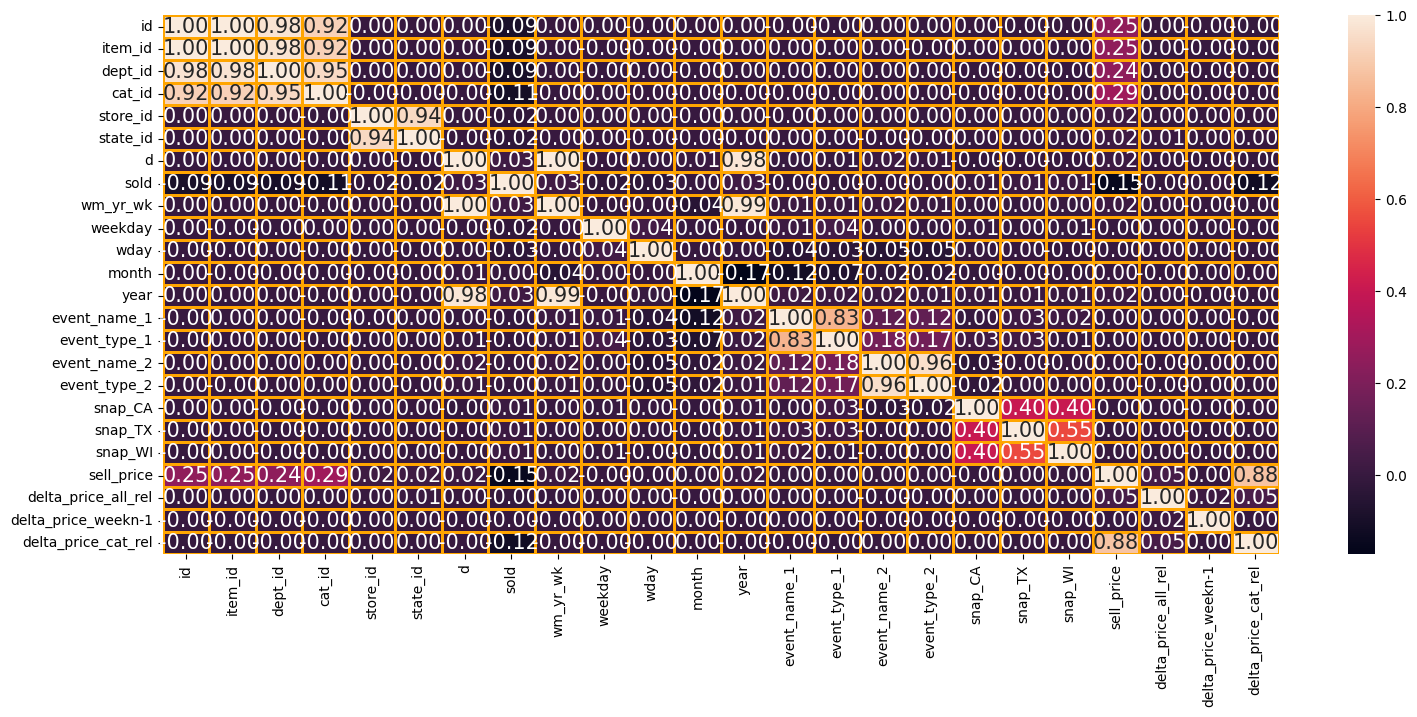

In [ ]:
plt.figure(figsize =(18,7))
sns.heatmap(df.corr(), annot = True, fmt = '0.2f', annot_kws = {'size' : 15}, linewidth = 2, linecolor = 'orange')
plt.show()

In [ ]:
# Introduce lags (days)
lags = [1, 2, 3, 7, 14, 28]
for lag in lags:
  df['sold_lag_'+str(lag)] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        as_index = False)['sold'].shift(lag).astype(np.float16)

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.drop(columns = ['weekday'])

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28
0,14370,1437,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,2,6,2016,16,3,2,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0
60034806,14339,1433,2,0,9,2,1969,0,11621,2,6,2016,16,3,2,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
60034807,14349,1434,2,0,9,2,1969,0,11621,2,6,2016,16,3,2,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0
60034808,14359,1435,2,0,9,2,1969,0,11621,2,6,2016,16,3,2,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Mean Encoding
# Total Average Sales by: item, state, store, cat and dept
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

# Sales average by
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [ ]:
#Rolling Average (Window) on actual sales (7 days)
#df['rolling_sold_mean'] = df.groupby(
  #  ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
   # lambda x: x.rolling(window=7).mean()).astype(np.float16)

# Rolling Average (window) on actual sales for the last n days
for days in [7, 14, 21, 28]:
    df['rolling_sold_mean_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=days).mean()).astype(np.float16)

In [ ]:
# Rolling Average (Window) on actual lag
#https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50/notebook
for window, lag in zip([7, 7, 28, 28], [7, 28, 7, 28]):
    df['rolling_lag_{}_win_{}'.format(window, lag)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold_lag_{}'.format(lag)].transform(
    lambda x: x.rolling(window=window).mean()).astype(np.float16)

In [ ]:
#Trends By SKU (Store + Item Id)
# Daily Average by SKU (Item Id + Store)
df['daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
df['avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
# Selling Trend
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)

# Drop Columns
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [ ]:
#Trends by SKU for all stores / By Item (All Stores)
# Daily Average by SKU (Item Id + Store)
df['item_daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'd'])['sold'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
df['item_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id'])['sold'].transform('mean').astype(np.float16)
# Selling Trend
df['item_selling_trend'] = (df['item_daily_avg_sold'] - df['item_avg_sold']).astype(np.float16)

# Drop Columns
df.drop(['item_daily_avg_sold','item_avg_sold'],axis=1,inplace=True)

In [ ]:
#Rolling Max (Window): Last n days
#df['rolling_sold_max'] = df.groupby(
  #  ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
   # lambda x: x.rolling(window=7).max()).astype(np.float16)

# Rolling Max (Window): Last n days
for days in [1, 2, 7, 14, 21, 28]:
    df['rolling_sold_max_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=days).max()).astype(np.float16)

In [ ]:
#Stock outs (Assumption: we will suppose that if you do not have sales for 3 days in a row you have a stock-out)

In [ ]:
# Sort the dataset by item_id and day
df.sort_values(['id', 'd'], ascending =[True, True], inplace = True)

# Mapping id change
df['id_change'] = df['id'].diff().fillna(0)
print("{:,} unique id with {:,} id changes".format(df.id.nunique(), df['id_change'].sum()))
# Zero Sale
df['zero_sale'] = (df['sold'] == 0) * (df['id_change']==False) * 1
df['stock_out_id'] = (df['zero_sale'].transform(
        lambda x: x.rolling(window=3).sum()).astype(np.float16)==3) * 1

# Drop useless columns
df.drop(['id_change', 'zero_sale'], axis = 1, inplace = True)

# Stock-Outs in the last n days ?
for n_days in [1, 2, 7]:
    df['stock_out_id_last_{}_days'.format(n_days)] = (df['stock_out_id'].transform(
        lambda x: x.rolling(window=n_days).sum()).astype(np.float16)>0) * 1

30,490 unique id with 30,489.0 id changes


In [ ]:
#store closed (Assumption: if the store total sales is zero => closed)
df['store_closed'] = (df.groupby(
    ['store_id', 'd'])['sold'].transform('sum').astype(np.float16) == 0) * 1

In [ ]:
# Store Closed = Sales zero
for n_days in [1, 2, 7]: # closed the last week
    df['store_closed_last_{}_days'.format(n_days)] = (df['store_closed'].transform(
        lambda x: x.rolling(window=n_days).sum()).astype(np.float16)>0) * 1

In [ ]:
df.drop(columns = ['weekday'])

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1612,0,0,0,0,0,0,1,3,11101,1,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,NaN,NaN,NaN,NaN,NaN,NaN,0.629883,1.215820,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.224609,2.224609,3.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
32102,0,0,0,0,0,0,2,0,11101,2,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,3.0,NaN,NaN,NaN,NaN,NaN,0.629883,1.215820,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0.0,3.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
62592,0,0,0,0,0,0,3,0,11101,3,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,0.0,3.0,NaN,NaN,NaN,NaN,0.629883,1.215820,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
93082,0,0,0,0,0,0,4,1,11101,4,2,2011,-1,-1,-1,-1,1,1,0,2.0,0.0,-0.0,-0.330865,0.0,0.0,3.0,NaN,NaN,NaN,0.629883,1.215820,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.225098,0.225098,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
123572,0,0,0,0,0,0,5,4,11101,5,2,2011,-1,-1,-1,-1,1,0,1,2.0,0.0,-0.0,-0.330865,1.0,0.0,0.0,NaN,NaN,NaN,0.629883,1.215820,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.224609,3.224609,4.0,4.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59911412,30489,3048,6,2,9,2,1965,0,11620,5,6,2016,-1,-1,-1,-1,0,1,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.607910,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
59941902,30489,3048,6,2,9,2,1966,0,11620,6,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.607910,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
59972392,30489,3048,6,2,9,2,1967,0,11620,7,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.607910,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
60002882,30489,3048,6,2,9,2,1968,0,11621,1,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.607910,0.214355,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.07141

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1612,0,0,0,0,0,0,1,3,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,NaN,NaN,NaN,NaN,NaN,NaN,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.224609,2.224609,3.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
32102,0,0,0,0,0,0,2,0,11101,3,2,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,3.0,NaN,NaN,NaN,NaN,NaN,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0.0,3.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
62592,0,0,0,0,0,0,3,0,11101,1,3,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,0.0,3.0,NaN,NaN,NaN,NaN,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
93082,0,0,0,0,0,0,4,1,11101,5,4,2,2011,-1,-1,-1,-1,1,1,0,2.0,0.0,-0.0,-0.330865,0.0,0.0,3.0,NaN,NaN,NaN,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.225098,0.225098,1.0,1.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
123572,0,0,0,0,0,0,5,4,11101,6,5,2,2011,-1,-1,-1,-1,1,0,1,2.0,0.0,-0.0,-0.330865,1.0,0.0,0.0,NaN,NaN,NaN,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.224609,3.224609,4.0,4.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
59911412,30489,3048,6,2,9,2,1965,0,11620,6,5,6,2016,-1,-1,-1,-1,0,1,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.60791,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
59941902,30489,3048,6,2,9,2,1966,0,11620,4,6,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.60791,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
59972392,30489,3048,6,2,9,2,1967,0,11620,0,7,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.60791,0.214355,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
60002882,30489,3048,6,2,9,2,1968,0,11621,2,1,6,2016,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.60791,0.214355,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1
60033372,30489,3048,6,2,9,2,1969,0,11621,3,2,6,2016,16,3,2,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.131348,1.027344,1.089844,0.716309,0.299805,0.299805,0.125488,0.131348,0.131348,1.089844,0.60791,0.214355,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071411,-0.125488,-0.125488,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1


In [ ]:
df.describe().applymap('{:,.2f}'.format)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
count,"60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","45,158,944.00","45,158,944.00","45,158,951.00","45,158,944.00","60,004,320.00","59,973,830.00","59,943,340.00","59,821,380.00","59,607,950.00","59,181,090.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","59,851,870.00","59,638,440.00","59,425,010.00","59,211,580.00","59,638,440.00","58,998,150.00","58,998,150.00","58,357,860.00","60,034,810.00","60,034,810.00","60,034,810.00","60,004,320.00","59,851,870.00","59,638,440.00","59,425,010.00","59,211,580.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00","60,034,810.00"
mean,"15,244.50","1,524.00",3.16,0.87,4.50,0.90,985.00,1.11,"11,347.09",3.00,4.00,6.33,"2,013.29",0.31,-0.81,-0.99,-1.00,0.33,0.33,0.33,nan,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,0.51,0.51,0.55,0.70,0.02,0.02,0.02,0.03
std,"8,801.70",880.17,1.92,0.89,2.87,0.83,568.40,3.84,155.24,2.00,2.00,3.42,1.58,5.02,0.70,0.14,0.06,0.47,0.47,0.47,0.00,0.04,nan,0.66,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.50,0.50,0.50,0.46,0.12,0.12,0.13,0.16
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,"11,101.00",0.00,1.00,1.00,"2,011.00",-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.01,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.03,0.70,0.56,0.18,0.18,0.01,0.03,0.03,0.70,0.34,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-128.88,-128.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"7,622.00",762.00,2.00,0.00,2.00,0.00,493.00,0.00,"11,219.00",1.00,2.00,3.00,"2,012.00",-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,2.18,0.00,0.00,-0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.22,1.03,0.95,0.72,0.70,0.70,0.19,0.22,0.22,0.95,0.61,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.54,-0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"15,244.50","1,524.00",3.00,1.00,4.50,1.00,985.00,0.00,"11,337.00",3.00,4.00,6.00,"2,013.00",-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,3.48,0.00,0.00,-0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.50,1.07,1.06,0.72,1.12,1.12,0.44,0.50,0.50,1.06,1.01,1.06,0.29,0.29,0.29,0.32,0.29,0.29,0.32,0.32,-0.19,-0.19,0.00,0.00,1.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
75%,"22,867.00","2,286.00",5.00,2.00,7.00,2.00,"1,477.00",1.00,"11,502.00",5.00,6.00,9.00,"2,015.00",-1.00,-1.00,-1.00,-1.00,1.00,1.00,1.00,5.88,0.00,0.00,0.27,1.00,1.00,1.00,1.00

In [ ]:
df.to_pickle('Data/data_features_improved.pkl')

In [ ]:
del df

In [ ]:
#MODELING AND PREDICTION

In [ ]:
# Import Data
data_size = 'improved'
data = pd.read_pickle('Data/data_features_{}.pkl'.format(data_size))

# Start records from 55th
start_row = 55
data = data[data['d'] >= start_row].copy()
print("{:,} records for the prepared data".format(len(data)))
data.head()

58,388,350 records for the prepared data


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1648072,0,0,0,0,0,0,55,0,11108,4,6,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322735,1.0,1.0,1.0,0.0,3.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.714355,0.856934,1.142578,1.500000,1.000000,1.571289,1.713867,NaN,-0.774902,-0.774902,0.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1678562,0,0,0,0,0,0,56,1,11108,0,7,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322735,0.0,1.0,1.0,0.0,0.0,4.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.856934,0.928711,1.142578,1.392578,1.000000,1.857422,1.642578,1.392578,0.225098,0.225098,1.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1709052,0,0,0,0,0,0,57,2,11109,2,1,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322735,1.0,0.0,1.0,1.0,1.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,1.000000,1.142578,1.392578,1.000000,2.000000,1.642578,1.357422,1.224609,1.224609,2.0,2.0,2.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1739542,0,0,0,0,0,0,58,2,11109,3,2,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322735,2.0,1.0,0.0,1.0,5.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.142578,0.785645,1.095703,1.392578,0.428467,2.000000,1.607422,1.428711,1.224609,1.224609,2.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0
1770032,0,0,0,0,0,0,59,0,11109,1,3,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322735,2.0,2.0,1.0,1.0,0.0,0.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,0.785645,1.095703,1.392578,0.571289,2.000000,1.642578,1.428711,-0.774902,-0.774902,0.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0


In [ ]:
len(data.columns)

66

In [ ]:
#Import Key Data
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
dict_data = {}
for list_name in LIST_NAME:
    dict_temp = pickle.load(open('Data/General/{}.p'.format(list_name), "rb"))
    dict_data[list_name] = dict_temp
    del dict_temp

In [ ]:
#Split features in groups or scenarios

In [ ]:
# Initial Features
INIT_FEAT = list(data.columns[0:21])

# Lags and averages
LAGAV_FEAT = list(data.columns[24:42])

# Rolling Means and Rolling Means on lag
ROLLMEAN_FEAT = list(data.columns[42:50])

# Trends and Rolling MAX
TREND_MAX_FEAT = list(data.columns[50:58])

# Stock-Out and Store Closed
# SO_CLOSED_FEAT = list(data.columns[58:66])
SO_CLOSED_FEAT = list(['stock_out_id', 'store_closed'])

# PRICE COMPARISON
PRICE_COMPARE = list(data.columns[21:24])

# Dictionnary with different steps
dict_features = {
    'STEP_1': INIT_FEAT,
    'STEP_2': INIT_FEAT+LAGAV_FEAT,
    'STEP_3': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT,
    'STEP_4': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT,
    'STEP_5': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT,
    'STEP_6': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT+PRICE_COMPARE,
}
LIST_STEPS = ['STEP_1', 'STEP_2', 'STEP_3', 'STEP_4', 'STEP_5', 'STEP_6']
LIST_STEPS_NAME = ['INITIAL_DATA', 'INITIAL + LAG + AVERAGES',
                  'INITIAL + LAG + AVERAGES + ROLLING MEAN',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON']
dict_stepname = dict(zip(LIST_STEPS, LIST_STEPS_NAME))

In [ ]:
#Train and Test Models
#Create Validation and Test sets

# Validation Set
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
# Validation Prediction
valid_preds = valid['sold']

# Test Set
test = data[data['d'] >= 1942][['id', 'd', 'sold']]
# Evaluation Prediction
eval_preds = test['sold']

In [ ]:
#Train and Test Models with different features

# Get the store ids
stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

# Dictionnary with errors each step
dict_error = {}

# Loop with the steps
for step in LIST_STEPS:

    # Folder for Models
    print('*****Prediction for STEP: {}*****'.format(dict_stepname[step]))
    FOLDER_MODEL = 'Model/{}/{}_Features_Improved/'.format(data_size, step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    COLS_SCOPE = dict_features[step]

    # DataFrame with filter scope
    data_scope = data[COLS_SCOPE].copy()

    # Validation Set
    valid = data_scope[(data_scope['d']>=1914) & (data_scope['d']<1942)][['id','d','sold']]
    # Validation Prediction
    valid_set = valid['sold']

    # Validation + Predicition for all stores by step
    df_validpred = pd.DataFrame()

    # Loop for training a model for each store
    for store in stores:

        # Dataframe for each store
        df = data_scope[data_scope['store_id']==store]

        # Train Data until day = 1914
        X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']

        # Validation Day: 1914 to 1942
        X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']

        # X_test with
        X_test = df[df['d']>=1942].drop('sold',axis=1)

        # Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )


        # Fit model
        model.fit(X_train, y_train,
                  eval_set = [(X_train,y_train),(X_valid,y_valid)],
                  eval_metric = 'rmse',
                  verbose = 0,
                  early_stopping_rounds = 20)

        # Compute Prediction
        valid_pred = model.predict(X_valid)

        # Actual Validation vs. Prediction
        df_valid = pd.DataFrame({
            'validation':valid_set[X_valid.index],
            'prediction':valid_pred,
            'store': d_store_id[store]
        })
        df_valid['error'] = df_valid['validation'] - df_valid['prediction']
        df_validpred = pd.concat([df_validpred, df_valid])
        # Save prediction
        df_valid.to_csv(FOLDER_MODEL + 'prediction_{}.csv'.format(step))

        # Save model
        filename = FOLDER_MODEL + 'model_features_total-' + str(d_store_id[store])+'.pkl'
        joblib.dump(model, filename)

        del model, X_train, y_train, X_valid, y_valid

    # Save Prediction for all stores
    df_validpred.to_csv(FOLDER_MODEL + 'prediction_{}.csv'.format(step))

    # Compute Error
    valid_rmse = 100 * np.sqrt(np.mean((df_validpred.validation.values - df_validpred.prediction.values) ** 2))/np.mean(df_validpred.validation.values)
    # Add Error in a Dictionnary
    dict_error[step] = valid_rmse
    print("For {}: RMSE = {}".format(dict_stepname[step], valid_rmse))

# Final DataFrame with error for all stores by STEP
df_error = pd.DataFrame({
    'STEP': LIST_STEPS,
    'STEP_NAME': [dict_stepname[step] for step in LIST_STEPS],
    'rmse': [dict_error[step] for step in LIST_STEPS]
    })
df_error.to_excel(FOLDER_MODEL + 'df_error.xlsx')
df_error

*****Prediction for STEP: INITIAL_DATA*****
For INITIAL_DATA: RMSE = 176.04002663081613
*****Prediction for STEP: INITIAL + LAG + AVERAGES*****
For INITIAL + LAG + AVERAGES: RMSE = 136.6290869834113
*****Prediction for STEP: INITIAL + LAG + AVERAGES + ROLLING MEAN*****
For INITIAL + LAG + AVERAGES + ROLLING MEAN: RMSE = 114.20255466480205
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX: RMSE = 6.994343417342642
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED: RMSE = 8.044405315029314
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX 

,STEP,STEP_NAME,rmse
0,STEP_1,INITIAL_DATA,176.040027
1,STEP_2,INITIAL + LAG + AVERAGES,136.629087
2,STEP_3,INITIAL + LAG + AVERAGES + ROLLING MEAN,114.202555
3,STEP_4,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,6.994343
4,STEP_5,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,8.044405
5,STEP_6,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,5.892866


*****Prot Features Importance for STEP: INITIAL_DATA*****


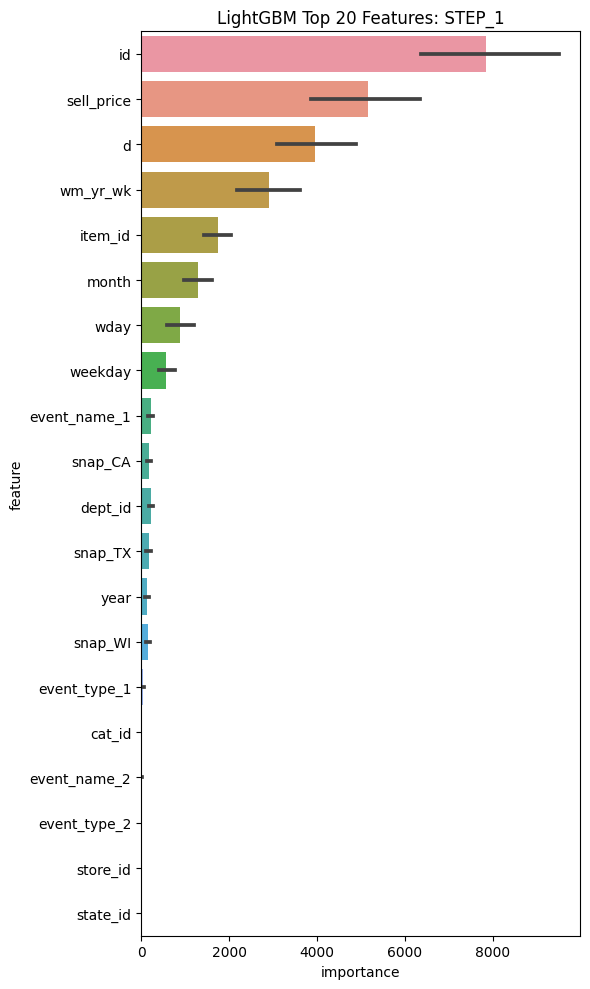

*****Prot Features Importance for STEP: INITIAL + LAG + AVERAGES*****


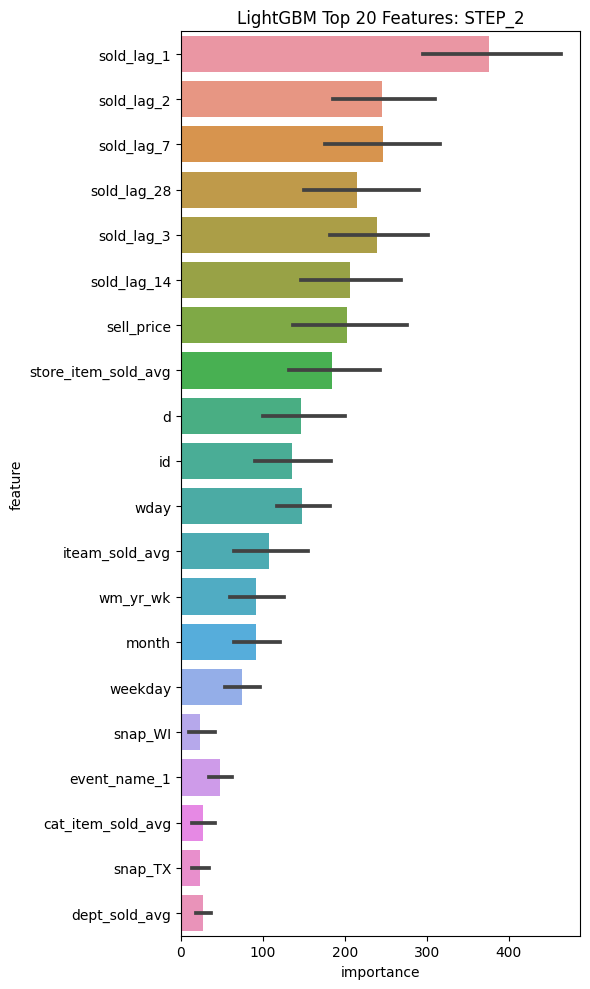

*****Prot Features Importance for STEP: INITIAL + LAG + AVERAGES + ROLLING MEAN*****


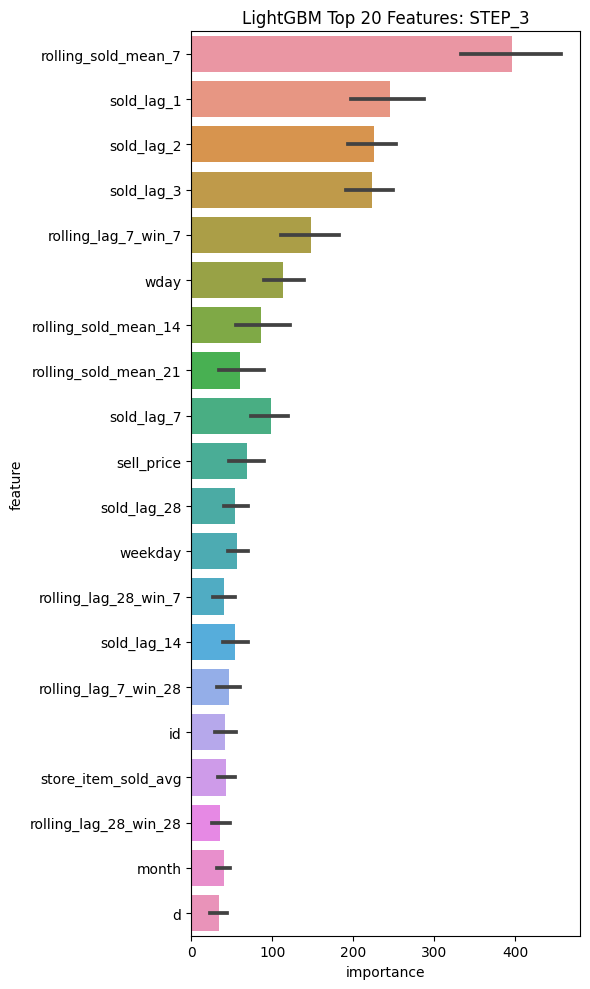

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX*****


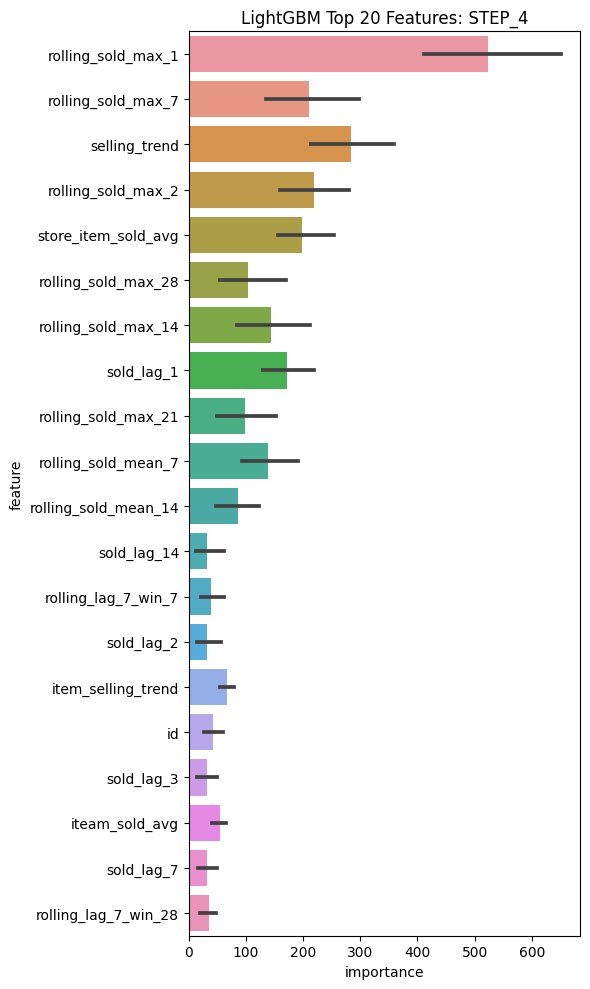

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED*****


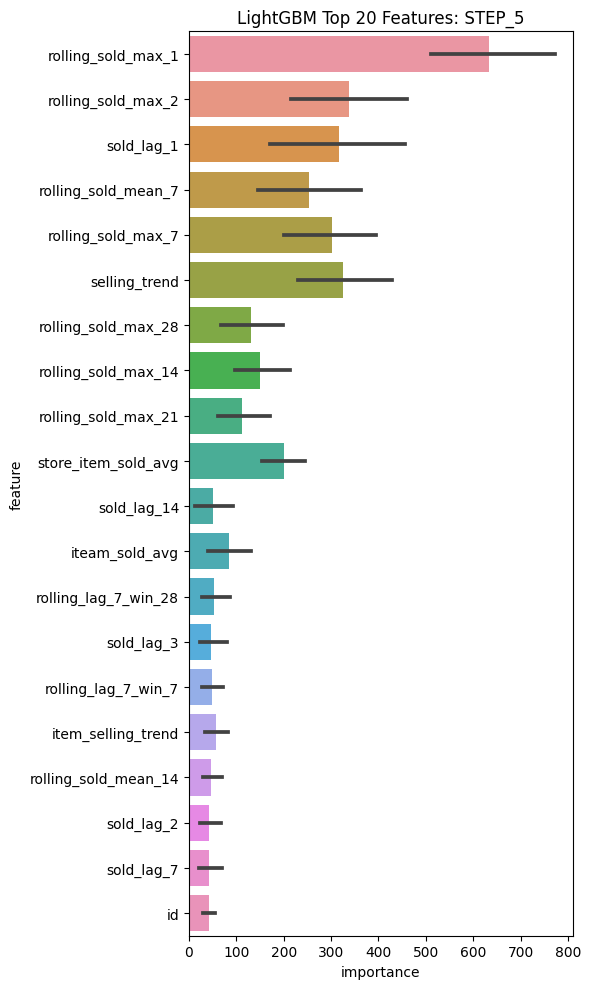

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON*****


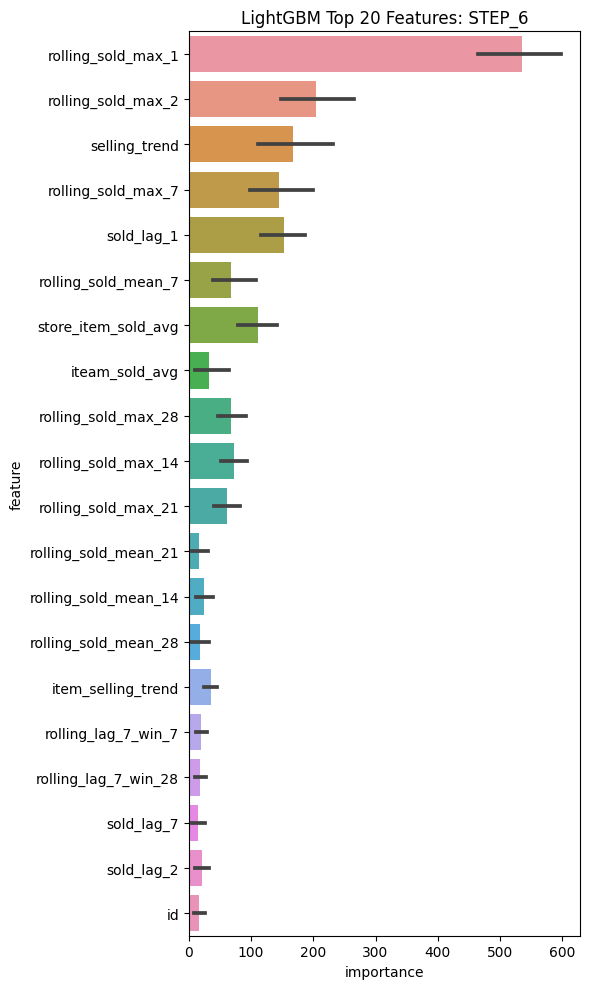

In [ ]:
# Folder for Models
for step in LIST_STEPS:
    print('*****Prot Features Importance for STEP: {}*****'.format(dict_stepname[step]))

    FOLDER_MODEL = 'Model/{}/{}_Features_Improved/'.format(data_size, step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    COLS_SCOPE = dict_features[step]

    feature_importance_df = pd.DataFrame()
    features = [f for f in COLS_SCOPE if f != 'sold']

    for store in stores:
        store_name = d_store_id[store]
        filename = FOLDER_MODEL + 'model_features_total-' + str(d_store_id[store])+'.pkl'
        # load model
        model = joblib.load(filename)

        # Create features importance for this model
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = store_name

        # Concat
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

    # Features Importances Analysis
    df_fi_mean = pd.DataFrame(feature_importance_df[
        ["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False))
    df_fi_mean.columns = ['importance']
    df_fi_mean['%_importance'] = (100 * df_fi_mean['importance']/df_fi_mean['importance'].sum(axis =0)).round(2)
    df_fi_mean.to_excel(FOLDER_MODEL + 'Features_Importance_{}.xlsx'.format(step))


    # Plot
    cols = df_fi_mean[:20].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    fig = plt.figure(figsize=(6,10))
    ax = fig.gca()
    sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Top 20 Features: {}'.format(step))
    plt.tight_layout()
    fig.savefig(FOLDER_MODEL + 'Features_Importance_{}.png'.format(step))
    plt.show()